In [1]:
import pandas as pd
import torch
import re

import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from torch import nn, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read + Preprocessing data

In [3]:
train_df = pd.read_csv("./dataset/train_health_content.csv")
test_df = pd.read_csv("./dataset/test_health_content.csv")

In [4]:
train_df

,id,title,text,rating,label
0,story_reviews_01118,Acupuncture May Help Ease Hot Flashes Tied to ...,"En Español\n\nMONDAY, April 25, 2011 (HealthDa...",3,0
1,story_reviews_01350,Aspirin May Cut Prostate Cancer Deaths,The findings were released at a news briefing ...,3,0
2,story_reviews_00749,Folic acid in pregnancy tied to lower autism risk,NEW YORK (Reuters Health) - Women who took ext...,4,0
3,story_reviews_01065,"Sleeptime Head-Cooling Cap Eases Insomnia, Stu...",By Jenifer Goodwin\n\nHealthDay Reporter\n\nTU...,4,0
4,news_reviews_00469,Chrono Therapeutics' Smoking Cessation Technol...,"CHICAGO, March 4, 2016 /PRNewswire/ -- Chrono ...",2,1
...,...,...,...,...,...
1337,story_reviews_00175,Immune-Focused Drug May Be New Weapon Against ...,"En Español\n\nMONDAY, Sept. 11, 2017 (HealthDa...",4,0
1338,story_reviews_00467,The Benefits of Intensive Cardiac Rehabilitati...,Despite considerable progress in prevention an...,3,0
1339,story_reviews_01529,Experimental flu treatment may help related virus,WASHINGTON (Reuters) - An experimental drug be...,3,0
1340,story_reviews_00892,Bypass Surgery Edges Stents For Heart Treatment,Bypass Surgery Edges Stents For Heart Treatmen...,4,0


In [5]:
train_df['input_text'] = train_df['title'] + " " + train_df['text']
test_df['input_text'] = test_df['title'] + " " + test_df['text']

In [6]:
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\W', ' ', text)   # Remove special characters
    text = re.sub(r'\d+', '', text)   # Remove digits
    text = text.strip()
    return text

In [7]:
train_df['input_text'] = train_df['input_text'].apply(clean_text)
test_df['input_text'] = test_df['input_text'].apply(clean_text)

# Build vocab

In [8]:
unique_train_labels = train_df['label'].unique()
class_to_int =  {label: i for i, label in enumerate(unique_train_labels)}
int_to_class = {i: label for label, i in class_to_int.items()}
train_tokens_to_indices_vocab = {"<pad>": 0, "<ukn>": 1}

idx = 2
for text, label in zip(train_df['input_text'], train_df['label']):
    tokenized_text = text.split(" ")
    for token in tokenized_text:
        if token not in train_tokens_to_indices_vocab:
            train_tokens_to_indices_vocab[token] = idx
            idx += 1

train_indices_to_tokens_vocab = {idx: token for token, idx in train_tokens_to_indices_vocab.items()}
print(len(train_tokens_to_indices_vocab))
print(list(train_tokens_to_indices_vocab.items())[:10])

26683
[('<pad>', 0), ('<ukn>', 1), ('acupuncture', 2), ('may', 3), ('help', 4), ('ease', 5), ('hot', 6), ('flashes', 7), ('tied', 8), ('to', 9)]


In [9]:
class InputTextDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe['input_text']
        self.y = dataframe['label']
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
def collate_fn_with_dict(token_vocab, label_vocab, unique_train_labels):
    def collate_fn(batch):
        inputs, labels = zip(*batch)
        
        tokens_indices = []
        labels_indices = []
        for tokens, label in zip(inputs, labels):
            if label not in unique_train_labels:
                continue
            label_indice = label_vocab[label]
            
            tokens_indices_aux = []
            
            for token in tokens:
                if token in token_vocab:
                    tokens_indices_aux.append(token_vocab[token])
                else:
                    tokens_indices_aux.append(token_vocab['<ukn>'])
            
            indices = torch.tensor(tokens_indices_aux, dtype=torch.long)
            
            tokens_indices.append(indices)
            labels_indices.append(label_indice)
            
        tokens_indices = pad_sequence(tokens_indices, batch_first=True, padding_value=token_vocab['<pad>'])
        labels_indices = torch.tensor(labels_indices)
        
        return tokens_indices, labels_indices
    return collate_fn

collate_fn = collate_fn_with_dict(train_tokens_to_indices_vocab, class_to_int, unique_train_labels)

In [11]:
train_dataset = InputTextDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

test_dataset = InputTextDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

In [12]:
print(f"Train dataset size: {train_dataset.X.shape}")
print(f"Test dataset size: {test_dataset.X.shape}")

Train dataset size: (1342,)
Test dataset size: (448,)


# Model Arhitecture:  MLP (embedding + 2 linear layares)

In [13]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=train_tokens_to_indices_vocab['<pad>'])
        self.fc1 = nn.Linear(embedding_dim, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
    
    def forward(self, x):
        embedding = self.embedding(x)
        embedding = torch.sum(embedding, dim=1)
        output = self.fc1(embedding)
        output = self.relu(output)
        output = self.fc2(output)
        return output

In [14]:
def test(model, test_loader, criterior, test_fn=False):
    model.eval()
    running_loss = 0.0
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterior(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss = running_loss / len(test_loader)
    
    if test_fn:
        print(classification_report(all_labels, all_preds, zero_division=0))
        test_accuracy = accuracy_score(all_labels, all_preds)
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

        print(f"Test Accuracy: {test_accuracy}")
        print(f"Test Precision: {test_precision}")
        print(f"Test Recall: {test_recall}")
        print(f"Test F1: {test_f1}")
    
    return test_loss

In [15]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    best_train_loss = float("inf")
    best_model = model
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_dataloader)
        test_loss = test(model, test_dataloader, criterion)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs},"
              f"train_loss {train_loss:.4f},"
              f"test_loss {test_loss:.4f}")
        
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            best_model = model
            torch.save(best_model.state_dict(), "./models/best_MLP_model.pt")
            print("Best model saved")
            
    print("Training finished")

In [198]:
train_losses = []
test_losses = []

nr_classes = len(class_to_int)
vocab_size = len(train_tokens_to_indices_vocab)
embedding_dim = 128
hidden_dim = 64
output_dim = nr_classes

model = Model(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

model.to(device)

Model(
  (embedding): Embedding(26683, 128, padding_idx=0)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [199]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=50)

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

Epoch 1/50,train_loss 44.5149,test_loss 10.8078
Best model saved


  4%|▍         | 2/50 [00:02<01:02,  1.30s/it]

Epoch 2/50,train_loss 11.6344,test_loss 9.3375
Best model saved


  6%|▌         | 3/50 [00:03<01:00,  1.28s/it]

Epoch 3/50,train_loss 10.1703,test_loss 8.2548
Best model saved


  8%|▊         | 4/50 [00:05<00:59,  1.29s/it]

Epoch 4/50,train_loss 8.8958,test_loss 7.8339
Best model saved


 10%|█         | 5/50 [00:06<00:57,  1.28s/it]

Epoch 5/50,train_loss 8.1918,test_loss 8.5480
Best model saved


 12%|█▏        | 6/50 [00:07<00:56,  1.28s/it]

Epoch 6/50,train_loss 7.9636,test_loss 6.2183
Best model saved


 14%|█▍        | 7/50 [00:08<00:54,  1.28s/it]

Epoch 7/50,train_loss 7.0025,test_loss 6.1030
Best model saved


 16%|█▌        | 8/50 [00:10<00:53,  1.27s/it]

Epoch 8/50,train_loss 6.8379,test_loss 5.1137
Best model saved


 18%|█▊        | 9/50 [00:11<00:52,  1.27s/it]

Epoch 9/50,train_loss 5.7970,test_loss 6.5984
Best model saved


 20%|██        | 10/50 [00:12<00:50,  1.27s/it]

Epoch 10/50,train_loss 6.0715,test_loss 5.6072


 22%|██▏       | 11/50 [00:14<00:49,  1.28s/it]

Epoch 11/50,train_loss 5.7285,test_loss 4.1223
Best model saved


 24%|██▍       | 12/50 [00:15<00:48,  1.28s/it]

Epoch 12/50,train_loss 5.2701,test_loss 3.8760
Best model saved


 26%|██▌       | 13/50 [00:16<00:47,  1.27s/it]

Epoch 13/50,train_loss 5.5749,test_loss 3.3699


 28%|██▊       | 14/50 [00:17<00:45,  1.27s/it]

Epoch 14/50,train_loss 4.9221,test_loss 4.5837
Best model saved


 30%|███       | 15/50 [00:19<00:44,  1.28s/it]

Epoch 15/50,train_loss 5.0283,test_loss 2.7377


 32%|███▏      | 16/50 [00:20<00:43,  1.28s/it]

Epoch 16/50,train_loss 3.6086,test_loss 6.8764
Best model saved


 34%|███▍      | 17/50 [00:21<00:42,  1.27s/it]

Epoch 17/50,train_loss 4.9069,test_loss 3.2882


 36%|███▌      | 18/50 [00:23<00:41,  1.28s/it]

Epoch 18/50,train_loss 3.2087,test_loss 4.4787
Best model saved


 38%|███▊      | 19/50 [00:24<00:39,  1.29s/it]

Epoch 19/50,train_loss 3.0138,test_loss 4.4773
Best model saved


 40%|████      | 20/50 [00:25<00:38,  1.28s/it]

Epoch 20/50,train_loss 3.2168,test_loss 2.9066


 42%|████▏     | 21/50 [00:26<00:36,  1.27s/it]

Epoch 21/50,train_loss 2.2507,test_loss 3.1394
Best model saved


 44%|████▍     | 22/50 [00:28<00:35,  1.27s/it]

Epoch 22/50,train_loss 2.5089,test_loss 7.8724


 46%|████▌     | 23/50 [00:29<00:34,  1.26s/it]

Epoch 23/50,train_loss 2.9721,test_loss 2.2594


 48%|████▊     | 24/50 [00:30<00:32,  1.27s/it]

Epoch 24/50,train_loss 2.5334,test_loss 4.6464


 50%|█████     | 25/50 [00:31<00:31,  1.26s/it]

Epoch 25/50,train_loss 2.0776,test_loss 1.6629
Best model saved


 52%|█████▏    | 26/50 [00:33<00:30,  1.28s/it]

Epoch 26/50,train_loss 2.7249,test_loss 1.9881


 54%|█████▍    | 27/50 [00:34<00:29,  1.27s/it]

Epoch 27/50,train_loss 1.8369,test_loss 1.5772
Best model saved


 56%|█████▌    | 28/50 [00:35<00:27,  1.27s/it]

Epoch 28/50,train_loss 1.6135,test_loss 2.2084
Best model saved


 58%|█████▊    | 29/50 [00:37<00:28,  1.35s/it]

Epoch 29/50,train_loss 2.2558,test_loss 4.2363


 60%|██████    | 30/50 [00:38<00:26,  1.33s/it]

Epoch 30/50,train_loss 2.4832,test_loss 4.2341


 62%|██████▏   | 31/50 [00:39<00:24,  1.30s/it]

Epoch 31/50,train_loss 2.1567,test_loss 2.3580


 64%|██████▍   | 32/50 [00:41<00:23,  1.28s/it]

Epoch 32/50,train_loss 1.9581,test_loss 1.5191


 66%|██████▌   | 33/50 [00:42<00:21,  1.27s/it]

Epoch 33/50,train_loss 1.6634,test_loss 3.1889


 68%|██████▊   | 34/50 [00:43<00:20,  1.27s/it]

Epoch 34/50,train_loss 2.1171,test_loss 1.0823


 70%|███████   | 35/50 [00:44<00:18,  1.26s/it]

Epoch 35/50,train_loss 1.7114,test_loss 1.9478


 72%|███████▏  | 36/50 [00:45<00:17,  1.24s/it]

Epoch 36/50,train_loss 2.0531,test_loss 1.1667


 74%|███████▍  | 37/50 [00:47<00:16,  1.26s/it]

Epoch 37/50,train_loss 1.5607,test_loss 1.0537
Best model saved


 76%|███████▌  | 38/50 [00:48<00:15,  1.27s/it]

Epoch 38/50,train_loss 1.6578,test_loss 1.0095


 78%|███████▊  | 39/50 [00:49<00:13,  1.27s/it]

Epoch 39/50,train_loss 1.7829,test_loss 1.6147


 80%|████████  | 40/50 [00:51<00:12,  1.27s/it]

Epoch 40/50,train_loss 2.1938,test_loss 5.1060


 82%|████████▏ | 41/50 [00:52<00:11,  1.28s/it]

Epoch 41/50,train_loss 2.0409,test_loss 1.2291


 84%|████████▍ | 42/50 [00:53<00:10,  1.27s/it]

Epoch 42/50,train_loss 2.1600,test_loss 1.4967


 86%|████████▌ | 43/50 [00:54<00:09,  1.29s/it]

Epoch 43/50,train_loss 2.2649,test_loss 3.6287


 88%|████████▊ | 44/50 [00:56<00:07,  1.30s/it]

Epoch 44/50,train_loss 1.4511,test_loss 1.6872
Best model saved


 90%|█████████ | 45/50 [00:57<00:06,  1.32s/it]

Epoch 45/50,train_loss 1.5440,test_loss 2.8068


 92%|█████████▏| 46/50 [00:58<00:05,  1.32s/it]

Epoch 46/50,train_loss 2.1705,test_loss 0.9253


 94%|█████████▍| 47/50 [01:00<00:03,  1.32s/it]

Epoch 47/50,train_loss 1.7373,test_loss 3.3536


 96%|█████████▌| 48/50 [01:01<00:02,  1.31s/it]

Epoch 48/50,train_loss 2.1025,test_loss 2.2900


 98%|█████████▊| 49/50 [01:02<00:01,  1.30s/it]

Epoch 49/50,train_loss 1.5772,test_loss 1.4558


100%|██████████| 50/50 [01:04<00:00,  1.28s/it]

Epoch 50/50,train_loss 1.2368,test_loss 1.0064
Best model saved
Training finished


In [202]:
test(model, test_dataloader, criterion, test_fn=True)

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       299
           1       0.46      0.15      0.22       149

    accuracy                           0.66       448
   macro avg       0.57      0.53      0.50       448
weighted avg       0.61      0.66      0.60       448

Test Accuracy: 0.6584821428571429
Test Precision: 0.4583333333333333
Test Recall: 0.1476510067114094
Test F1: 0.2233502538071066


1.0064231898369533

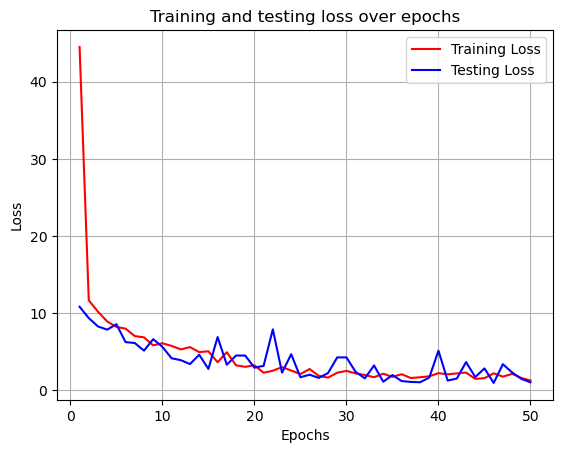

In [204]:
def plot_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='Red')
    plt.plot(epochs, test_losses, label='Testing Loss', color='Blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and testing loss over epochs")
    plt.legend()
    plt.grid()
    plt.show()


plot_losses(train_losses, test_losses)